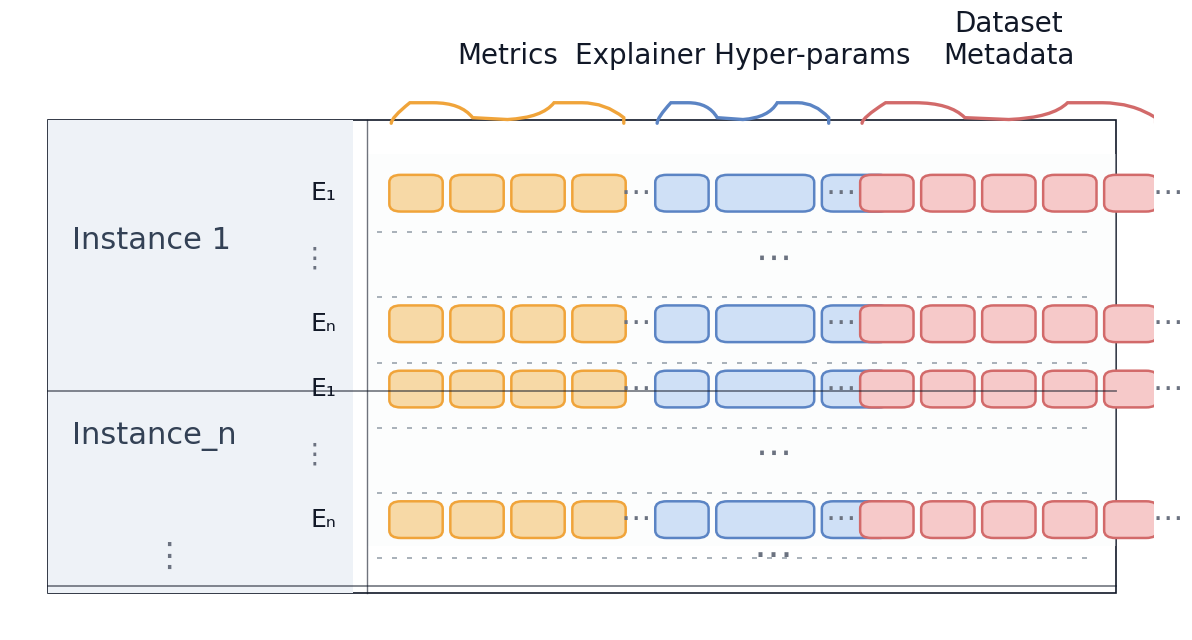

In [1]:
"""
Table-style visualization for "Instance -> many Explanations -> vector parts"
- Left column: Instances spanning multiple explanation rows (multi-row blocks)
- Each explanation row: colored rounded boxes representing a concatenated vector
  (Metrics | Explainer Hyper-params | Dataset Metadata)
- Curly braces (approx.) + labels above the vector
- Ellipses to indicate "many explanations" and "many features"
"""

import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Rectangle, PathPatch
from matplotlib.path import Path

# ----------------------------
# Helpers
# ----------------------------
def rounded_box(ax, x, y, w, h, face, edge, lw=1.8, r=0.08, alpha=1.0):
    """Rounded rectangle centered vertically on y (y is baseline), using FancyBboxPatch."""
    patch = FancyBboxPatch(
        (x, y), w, h,
        boxstyle=f"round,pad=0.02,rounding_size={r}",
        facecolor=face, edgecolor=edge, linewidth=lw, alpha=alpha
    )
    ax.add_patch(patch)
    return patch

def dashed_row_sep(ax, x0, x1, y, color="#9aa3ad", lw=1.2, dash=(3, 6)):
    ax.plot([x0, x1], [y, y], color=color, linewidth=lw, dashes=dash)

def draw_brace(ax, x0, x1, y, height=0.35, color="k", lw=2.0):
    """
    Draw an approximate curly brace over [x0, x1] at height y (opening downward).
    This is a simple cubic-bezier style brace made from 2 mirrored curves + center notch.
    """
    mid = (x0 + x1) / 2.0
    dx = (x1 - x0)

    # Control points tuned for a pleasant brace shape
    verts = [
        (x0, y),
        (x0, y + height * 0.15),
        (x0 + dx * 0.08, y + height * 0.55),
        (x0 + dx * 0.18, y + height * 0.55),

        (x0 + dx * 0.30, y + height * 0.55),
        (x0 + dx * 0.35, y + height * 0.15),
        (mid, y + height * 0.10),

        (x1 - dx * 0.35, y + height * 0.15),
        (x1 - dx * 0.30, y + height * 0.55),
        (x1 - dx * 0.18, y + height * 0.55),

        (x1 - dx * 0.08, y + height * 0.55),
        (x1, y + height * 0.15),
        (x1, y),
    ]
    codes = [
        Path.MOVETO,
        Path.CURVE3, Path.CURVE3, Path.LINETO,
        Path.CURVE3, Path.CURVE3, Path.LINETO,
        Path.CURVE3, Path.CURVE3, Path.LINETO,
        Path.CURVE3, Path.CURVE3, Path.LINETO,
    ]
    path = Path(verts, codes)
    ax.add_patch(PathPatch(path, facecolor="none", edgecolor=color, lw=lw, capstyle="round"))

def dots(ax, x, y, s=22, color="#6b7280"):
    ax.text(x, y, "⋯", ha="center", va="center", fontsize=s, color=color)

def v_dots(ax, x, y, s=18, color="#6b7280"):
    ax.text(x, y, "⋮", ha="center", va="center", fontsize=s, color=color)

# ----------------------------
# Layout parameters (tweakable)
# ----------------------------
FIG_W, FIG_H = 12, 6.5

# Column x-positions
x_instance0 = 0.4
w_instance = 2.3

x_expl_lbl0 = x_instance0 + w_instance
w_expl_lbl = 0.9

x_vec0 = x_expl_lbl0 + w_expl_lbl + 0.4
x_right = 11.6

# Vector segment counts (how many little boxes to draw per part)
n_metrics = 4
n_hparams = 3
n_dmeta = 5

# Sizes
box_h = 0.55
box_w = 0.52
box_gap = 0.12
seg_gap = 0.35  # gap between segments (metrics | hparams | dmeta)

row_h = 1.05    # row spacing
pad_y = 0.45    # top padding

# Colors (soft fill + stronger edge)
COL_MET_F = "#f7d9a6"
COL_MET_E = "#f0a43a"

COL_HP_F  = "#cfe0f6"
COL_HP_E  = "#5b84c4"

COL_DM_F  = "#f6c9c9"
COL_DM_E  = "#d26a6a"

# Background tints
BG_LEFT = "#eef2f7"
BG_ROW  = "#f7fafc"

# ----------------------------
# Define the "table" structure
# ----------------------------
# We’ll show:
#  - Instance 1 with E1, (vdots), En
#  - Instance_n with E1, (vdots), En
# Total visible explanation rows per instance block: 3 (top, dots, bottom)
instances = [
    ("Instance 1", ["E₁", "⋮", "Eₙ"]),
    ("Instance_n", ["E₁", "⋮", "Eₙ"]),
]

# Compute total rows
rows_per_instance = 3
total_rows = len(instances) * rows_per_instance + 1  # +1 for a bottom ellipsis row

# y coordinates: top row at high y, going down
y_top = pad_y + total_rows * row_h

# ----------------------------
# Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(FIG_W, FIG_H))
ax.set_xlim(0, 12)
ax.set_ylim(0, y_top + 1.2)
ax.axis("off")

# Draw a light table background
table_x0 = x_instance0
table_y0 = 0.6
table_w  = x_right - table_x0
table_h  = y_top - 0.2
ax.add_patch(Rectangle((table_x0, table_y0), table_w, table_h, facecolor="white", edgecolor="#111827", lw=1.2))

# Left column background
ax.add_patch(Rectangle((x_instance0, table_y0), w_instance + w_expl_lbl, table_h, facecolor=BG_LEFT, edgecolor="none"))

# Vertical separator between left and vector area
ax.plot([x_vec0 - 0.25, x_vec0 - 0.25], [table_y0, table_y0 + table_h], color="#111827", lw=1.0, alpha=0.6)

# --- Braces + labels for vector parts (top) ---
# Determine segment x ranges
x_m0 = x_vec0
x_m1 = x_m0 + n_metrics * (box_w + box_gap) - box_gap

x_h0 = x_m1 + seg_gap
x_h1 = x_h0 + n_hparams * (box_w + box_gap) - box_gap

x_d0 = x_h1 + seg_gap
x_d1 = x_d0 + n_dmeta * (box_w + box_gap) - box_gap

brace_y = y_top + 0.35
draw_brace(ax, x_m0, x_m1, brace_y, height=0.6, color=COL_MET_E, lw=2.4)
draw_brace(ax, x_h0, x_h1, brace_y, height=0.6, color=COL_HP_E, lw=2.4)
draw_brace(ax, x_d0, x_d1, brace_y, height=0.6, color=COL_DM_E, lw=2.4)

ax.text((x_m0+x_m1)/2, brace_y + 0.85, "Metrics", ha="center", va="bottom", fontsize=20, color="#111827")
ax.text((x_h0+x_h1)/2, brace_y + 0.85, "Explainer Hyper-params", ha="center", va="bottom", fontsize=20, color="#111827")
ax.text((x_d0+x_d1)/2, brace_y + 0.85, "Dataset\nMetadata", ha="center", va="bottom", fontsize=20, color="#111827")

# --- Draw rows ---
row_idx = 0
y = y_top - row_h

def draw_vector_row(y0, show_feature_dots=True):
    """Draw one explanation vector row at y0."""
    # Metrics boxes
    x = x_m0
    for i in range(n_metrics):
        rounded_box(ax, x, y0, box_w, box_h, COL_MET_F, COL_MET_E, r=0.12)
        x += box_w + box_gap
    # Feature dots inside metrics segment (optional)
    if show_feature_dots:
        dots(ax, x_m1 + seg_gap * 0.35, y0 + box_h * 0.5, s=22)

    # Hyperparam boxes
    x = x_h0
    # Mix box widths a bit for visual interest (like your reference)
    widths = [box_w, box_w*1.9, box_w*1.3]
    for w in widths[:n_hparams]:
        rounded_box(ax, x, y0, w, box_h, COL_HP_F, COL_HP_E, r=0.12)
        x += w + box_gap
    if show_feature_dots:
        dots(ax, x_h1 + seg_gap * 0.35, y0 + box_h * 0.5, s=22)

    # Dataset meta boxes
    x = x_d0
    for i in range(n_dmeta):
        rounded_box(ax, x, y0, box_w, box_h, COL_DM_F, COL_DM_E, r=0.12)
        x += box_w + box_gap
    if show_feature_dots:
        dots(ax, x_d1 + seg_gap * 0.35, y0 + box_h * 0.5, s=22)

for inst_name, expl_rows in instances:
    # Multi-row instance cell (spans 3 rows)
    span_h = rows_per_instance * row_h
    inst_y0 = y - (rows_per_instance - 1) * row_h - 0.12
    ax.text(x_instance0 + 0.25, inst_y0 + span_h * 0.55, inst_name,
            ha="left", va="center", fontsize=22, color="#334155")

    # Draw each explanation row for this instance
    for r, expl in enumerate(expl_rows):
        # light row band in vector area (optional subtle)
        ax.add_patch(Rectangle((x_vec0 - 0.25, y - 0.15), x_right - (x_vec0 - 0.25), row_h,
                               facecolor=BG_ROW, edgecolor="none", alpha=0.35))

        # Explanation label in the small left column
        if expl == "⋮":
            v_dots(ax, x_expl_lbl0 + w_expl_lbl * 0.55, y + box_h * 0.5, s=20)
        else:
            ax.text(x_expl_lbl0 + w_expl_lbl * 0.65, y + box_h * 0.5, expl,
                    ha="center", va="center", fontsize=18, color="#111827")

        # Draw vector row (skip full row for vertical dots row)
        if expl != "⋮":
            draw_vector_row(y, show_feature_dots=True)
        else:
            # Put centered dots across the vector area
            dots(ax, (x_m0 + x_d1) / 2, y + box_h * 0.5, s=26)

        # dashed separator between explanation rows (like your mock)
        dashed_row_sep(ax, x_vec0 - 0.15, x_right - 0.2, y - 0.35)

        y -= row_h

    # thicker separator between instances
    ax.plot([table_x0, x_right], [y + 0.25, y + 0.25], color="#111827", lw=1.3, alpha=0.55)

# Bottom ellipsis for many instances
ax.text(x_instance0 + w_instance * 0.55, y + row_h * 0.7, "⋮", ha="center", va="center", fontsize=24, color="#6b7280")
dots(ax, (x_m0 + x_d1) / 2, y + row_h * 0.7, s=28)

plt.tight_layout()
plt.show()


In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyBboxPatch

def draw_schematic_svg(
    out_svg="schematic.svg",
    fig_w=13,
    fig_h=5.3,
    left_col_w=0.24,   # <-- make this smaller to narrow the first column
):
    # Coordinate system: (0,0) bottom-left to (1,1) top-right
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis("off")

    # --- Colors (approximate the reference) ---
    border = "#2b2f38"
    left_fill = "#eef2f6"
    orange_fill, orange_edge = "#f8d7a8", "#f39c12"
    blue_fill,   blue_edge   = "#d7e6ff", "#4d79c7"
    red_fill,    red_edge    = "#f7c9c9", "#d46a6a"
    label_color = "#2f3a4a"
    dots_color = "#6c7684"

    # --- Outer border ---
    ax.add_patch(Rectangle((0, 0), 1, 1, fill=False, ec=border, lw=2))

    # --- Left column background and divider ---
    ax.add_patch(Rectangle((0, 0), left_col_w, 1, facecolor=left_fill, edgecolor="none"))
    ax.plot([left_col_w, left_col_w], [0, 1], color=border, lw=2)

    # --- Horizontal separators (top instance block, bottom instance block) ---
    y_mid = 0.50
    ax.plot([0, 1], [y_mid, y_mid], color=border, lw=1.6)

    # --- Left column labels ---
    ax.text(left_col_w * 0.35, 0.74, "Instance 1", va="center", ha="center",
            fontsize=20, color=label_color)
    ax.text(left_col_w * 0.88, 0.74, "⋮", va="center", ha="center",
            fontsize=18, color=label_color)

    ax.text(left_col_w * 0.35, 0.26, "Instance_n", va="center", ha="center",
            fontsize=20, color=label_color)
    ax.text(left_col_w * 0.35, 0.12, "⋮", va="center", ha="center",
            fontsize=18, color=label_color)

    # --- Right side: E1/En labels per instance block (two rows each) ---
    def e_labels(y_top, y_bottom):
        # small labels just to the right of divider
        x = left_col_w + 0.02
        ax.text(x, y_top,  "E$_1$", va="center", ha="right", fontsize=16, color=label_color)
        ax.text(x, y_bottom,"E$_n$", va="center", ha="right", fontsize=16, color=label_color)

    # top block (two rows)
    e_labels(0.86, 0.62)
    # bottom block (two rows)
    e_labels(0.36, 0.12)

    # --- Token drawing helper ---
    def token(x, y, w, h, fc, ec, lw=2.0, r=0.012):
        ax.add_patch(
            FancyBboxPatch(
                (x, y), w, h,
                boxstyle=f"round,pad=0,rounding_size={r}",
                facecolor=fc, edgecolor=ec, linewidth=lw
            )
        )

    # --- Sequence row helper (orange ... blue ... red) ---
    def sequence_row(y_center):
        right_x0 = left_col_w + 0.06
        right_x1 = 0.98
        row_h = 0.10
        t_h = 0.075
        t_w = 0.045
        gap = 0.013

        y = y_center - t_h / 2

        # Orange group
        x = right_x0
        for _ in range(4):
            token(x, y, t_w, t_h, orange_fill, orange_edge)
            x += t_w + gap

        ax.text(x + 0.010, y_center, "⋯", va="center", ha="center",
                fontsize=18, color=dots_color)
        x += 0.040

        # Blue group
        for _ in range(3):
            token(x, y, t_w, t_h, blue_fill, blue_edge)
            x += t_w + gap

        ax.text(x + 0.010, y_center, "⋯", va="center", ha="center",
                fontsize=18, color=dots_color)
        x += 0.040

        # Red group
        for _ in range(3):
            token(x, y, t_w, t_h, red_fill, red_edge)
            x += t_w + gap

    # Draw the four rows (two per instance block)
    for yc in [0.86, 0.62, 0.36, 0.12]:
        sequence_row(yc)

    # Tight-ish layout and save as SVG
    plt.savefig(out_svg, format="svg", bbox_inches="tight")
    plt.close(fig)

if __name__ == "__main__":import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyBboxPatch

def draw_schematic_svg(
    out_svg="schematic.svg",
    fig_w=13,
    fig_h=5.3,
    instance_col_w=0.20,   # width of "Instance" column
    e_col_w=0.08           # width of "E1, E2, ..., En" column
):
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis("off")

    # --- Colors ---
    border = "#2b2f38"
    left_fill = "#eef2f6"
    e_fill = "#f7f9fc"
    orange_fill, orange_edge = "#f8d7a8", "#f39c12"
    blue_fill,   blue_edge   = "#d7e6ff", "#4d79c7"
    red_fill,    red_edge    = "#f7c9c9", "#d46a6a"
    label_color = "#2f3a4a"
    dots_color = "#6c7684"

    # --- Column boundaries ---
    x_instance_end = instance_col_w
    x_e_end = instance_col_w + e_col_w
    x_right_start = x_e_end

    # --- Outer border ---
    ax.add_patch(Rectangle((0, 0), 1, 1, fill=False, ec=border, lw=2))

    # --- Backgrounds ---
    ax.add_patch(Rectangle((0, 0), instance_col_w, 1, facecolor=left_fill, edgecolor="none"))
    ax.add_patch(Rectangle((x_instance_end, 0), e_col_w, 1, facecolor=e_fill, edgecolor="none"))

    # --- Vertical separators ---
    ax.plot([x_instance_end, x_instance_end], [0, 1], color=border, lw=2)
    ax.plot([x_e_end, x_e_end], [0, 1], color=border, lw=2)

    # --- Horizontal separator between instances ---
    y_mid = 0.50
    ax.plot([0, 1], [y_mid, y_mid], color=border, lw=1.6)

    # --- Instance labels ---
    ax.text(instance_col_w * 0.45, 0.74, "Instance 1",
            ha="center", va="center", fontsize=20, color=label_color)
    ax.text(instance_col_w * 0.90, 0.74, "⋮",
            ha="center", va="center", fontsize=18, color=label_color)

    ax.text(instance_col_w * 0.45, 0.26, "Instance_n",
            ha="center", va="center", fontsize=20, color=label_color)
    ax.text(instance_col_w * 0.45, 0.12, "⋮",
            ha="center", va="center", fontsize=18, color=label_color)

    # --- E-column labels ---
    def e_column_labels(y_vals):
        for i, y in enumerate(y_vals):
            label = f"E$_{i+1}$" if i < len(y_vals) - 1 else "E$_n$"
            ax.text(
                x_instance_end + e_col_w / 2,
                y,
                label,
                ha="center",
                va="center",
                fontsize=16,
                color=label_color
            )

    e_column_labels([0.86, 0.62])
    e_column_labels([0.36, 0.12])

    # --- Token helper ---
    def token(x, y, w, h, fc, ec, lw=2.0, r=0.012):
        ax.add_patch(
            FancyBboxPatch(
                (x, y), w, h,
                boxstyle=f"round,pad=0,rounding_size={r}",
                facecolor=fc,
                edgecolor=ec,
                linewidth=lw
            )
        )

    # --- Sequence row ---
    def sequence_row(y_center):
        x = x_right_start + 0.03
        t_w, t_h = 0.045, 0.075
        gap = 0.013
        y = y_center - t_h / 2

        for _ in range(4):
            token(x, y, t_w, t_h, orange_fill, orange_edge)
            x += t_w + gap

        ax.text(x + 0.01, y_center, "⋯", ha="center", va="center",
                fontsize=18, color=dots_color)
        x += 0.04

        for _ in range(3):
            token(x, y, t_w, t_h, blue_fill, blue_edge)
            x += t_w + gap

        ax.text(x + 0.01, y_center, "⋯", ha="center", va="center",
                fontsize=18, color=dots_color)
        x += 0.04

        for _ in range(3):
            token(x, y, t_w, t_h, red_fill, red_edge)
            x += t_w + gap

    # --- Draw rows ---
    for yc in [0.86, 0.62, 0.36, 0.12]:
        sequence_row(yc)

    # --- Save SVG ---
    plt.savefig(out_svg, format="svg", bbox_inches="tight")
    plt.close(fig)


if __name__ == "__main__":
    draw_schematic_svg(
        out_svg="plot_with_e_column.svg",
        instance_col_w=0.20,
        e_col_w=0.08
    )
    print("Saved: plot_with_e_column.svg")

    # draw_schematic_svg(
    #     out_svg="plot_like_reference.svg",
    #     left_col_w=0.22  # narrower first column; tweak as you like
    # )
    # print("Saved: plot_like_reference.svg")


Saved: plot_with_e_column.svg
